# TensorFlow Transfer Learning - Exercises

Dataset:

- https://www.kaggle.com/datasets/gpiosenka/balls-image-classification

### Import Libraries

- Import VGG16

In [24]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import tensorflow as tf
import zipfile

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix, classification_report

### Enable Mixed Precision

- Ensure a capable GPU is attached to the Google Colab Workbook

In [3]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [2]:
!nvidia-smi

Sat Jul 16 10:49:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Connect Colab to Kaggle and Get Dataset

- Download and unzip the Dataset

- https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gpiosenka/balls-image-classification

 88% 162M/183M [00:04<00:00, 39.2MB/s]
100% 183M/183M [00:04<00:00, 39.4MB/s]


In [6]:
uz = zipfile.ZipFile('balls-image-classification.zip')
uz.extractall()
uz.close()

### Explore the Data

- How many images?
- What is the size of the images?
- What percent do we need to be above?

(224, 224, 3)


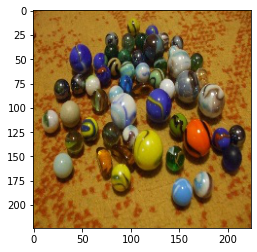

In [11]:
path = 'train/'
category='marble/'

target = path + category

image = random.choice(os.listdir(target))

img = mpimage.imread(target + image)
print(img.shape)
plt.imshow(img)

In [12]:
total = 0
for dirs, fols, files in os.walk('train'):
  print(f'{dirs}, {len(fols)}, {len(files)}')
  if len(fols) < 1:
    total += len(files)
print(f'Total Files: {total}')

train, 26, 0
train/pokeman balls, 0, 86
train/baseball, 0, 112
train/tennis ball, 0, 139
train/volley ball, 0, 131
train/meat ball, 0, 137
train/marble, 0, 131
train/paint balls, 0, 32
train/golf ball, 0, 106
train/medicine ball, 0, 77
train/football, 0, 112
train/brass, 0, 113
train/bowling ball, 0, 145
train/eyeballs, 0, 139
train/cannon ball, 0, 183
train/water polo ball, 0, 139
train/basketball, 0, 116
train/soccer ball, 0, 167
train/billiard ball, 0, 143
train/puffballs, 0, 106
train/screwballs, 0, 140
train/cricket ball, 0, 150
train/wrecking ball, 0, 69
train/beachballs, 0, 92
train/wiffle ball, 0, 99
train/tether ball, 0, 105
train/buckeyballs, 0, 82
Total Files: 3051


### Normalize and Batch the Data

- Use image_dataset_from_directory
- Get the class_names from test_data
- Enable Prefetching and Caching on the datasets

In [23]:
train_dir = 'train/'
test_dir = 'test/'

train_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(224, 224)
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(224,224)
)

train_data = train_data.cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tf.data.AUTOTUNE)

Found 3051 files belonging to 26 classes.
Found 130 files belonging to 26 classes.


In [20]:
test_data.class_names

['baseball',
 'basketball',
 'beachballs',
 'billiard ball',
 'bowling ball',
 'brass',
 'buckeyballs',
 'cannon ball',
 'cricket ball',
 'eyeballs',
 'football',
 'golf ball',
 'marble',
 'meat ball',
 'medicine ball',
 'paint balls',
 'pokeman balls',
 'puffballs',
 'screwballs',
 'soccer ball',
 'tennis ball',
 'tether ball',
 'volley ball',
 'water polo ball',
 'wiffle ball',
 'wrecking ball']

In [18]:
test_data.

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>

In [21]:
class_names = dict(zip(
    test_data.class_names,
    np.arange(len(test_data.class_names))
))

In [22]:
class_names

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

### 1st Model - VGG16 Default

- Create a model with VGG16 with Defaults
 - Add the Input Layers 
- Add in the Dense Layer

- Build the model and look at the summary

- Train the Model

In [29]:
i = tf.keras.layers.Input([224, 224, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)

x = tf.keras.applications.vgg16.preprocess_input(x)

base_model = VGG16()

x = base_model(x)

output = Dense(26, activation='softmax')(x)

model_1 = tf.keras.Model(inputs=[i], outputs=output)

# model_1.build(input_shape=(224,224,3))

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

history_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 76s 358ms/step - loss: nan - accuracy: 0.0380 - val_loss: nan - val_accuracy: 0.0385
Epoch 2/5
96/96 [==============================] - 24s 253ms/step - loss: nan - accuracy: 0.0367 - val_loss: nan - val_accuracy: 0.0385
Epoch 3/5
96/96 [==============================] - 25s 255ms/step - loss: nan - accuracy: 0.0367 - val_loss: nan - val_accuracy: 0.0385
Epoch 4/5
96/96 [==============================] - 25s 257ms/step - loss: nan - accuracy: 0.0367 - val_loss: nan - val_accuracy: 0.0385
Epoch 5/5
96/96 [==============================] - 25s 259ms/step - loss: nan - accuracy: 0.0367 - val_loss: nan - val_accuracy: 0.0385


In [26]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_______________________________________________

In [28]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 26)                2602

### 2nd Model - VGG16 Trainable False

- Disable Training on all Layers

- What is the difference in time between the first and second model?

In [32]:
i = tf.keras.layers.Input(shape=[224,224,3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)

x = tf.keras.applications.vgg16.preprocess_input(x)

base_model = VGG16()

for layer in base_model.layers:
  layer.trainable = False
  print(layer, layer.trainable)

x = base_model(x)

output = Dense(26, activation='softmax')(x)

model_2 = Model(i, output)

model_2.build(input_shape=(224,224,3))

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

<keras.engine.input_layer.InputLayer object at 0x7fb6b00ab490> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b094b490> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b024d410> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb6b00cc310> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b01a9090> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b022f4d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb6b00c3d90> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b01403d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b00b3690> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b023bdd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb6b0140910> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b01a0a50> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b0262310> False
<keras.layers.convolutional.Conv2D object at 0x7fb6b0128c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb6b0259cd0>

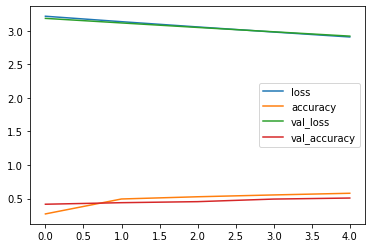

In [33]:
pd.DataFrame(history_2.history).plot()

### 3rd Model - VGG16 - Include Top False

- Include Top: False
- Have to specify Input Shape
- Have to have some kind of pooling, either max or average
- Disable Training on all layers

In [46]:
i = tf.keras.layers.Input(shape=[224,224,3], dtype=tf.uint8)

x = tf.cast(i, tf.float32)

x = tf.keras.applications.vgg16.preprocess_input(x)

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg'
)

for layer in base_model.layers:
  layer.trainable = False

x = base_model(x)

x = Dense(26)(x)

# For mixed precision we have to break out the very final layer
output = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)

model_3 = Model(i, output)

model_3.build(input_shape=(224,224,3))

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

history_3 = model_3.fit(
    train_data,
    validation_data=test_data,
    epochs=5

)


Epoch 1/5
96/96 [==============================] - 10s 87ms/step - loss: 5.9033 - accuracy: 0.3700 - val_loss: 1.7053 - val_accuracy: 0.7231
Epoch 2/5
96/96 [==============================] - 8s 85ms/step - loss: 0.9703 - accuracy: 0.7984 - val_loss: 0.8365 - val_accuracy: 0.8692
Epoch 3/5
96/96 [==============================] - 8s 84ms/step - loss: 0.4506 - accuracy: 0.8918 - val_loss: 0.5696 - val_accuracy: 0.9000
Epoch 4/5
96/96 [==============================] - 8s 85ms/step - loss: 0.2354 - accuracy: 0.9358 - val_loss: 0.4542 - val_accuracy: 0.9154
Epoch 5/5
96/96 [==============================] - 8s 85ms/step - loss: 0.1352 - accuracy: 0.9617 - val_loss: 0.4040 - val_accuracy: 0.9231


In [36]:
model_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_7 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_5 (Dense)             (None, 26)                2602

In [38]:
model_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_8 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_6 (Dense)             (None, 26)                2602

In [42]:
model_3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_11 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 dense_9 (Dense)             (None, 7, 7, 26)          133

In [45]:
model_3.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_13 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_13  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_13 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_10 (Dense)            (None, 26)                133

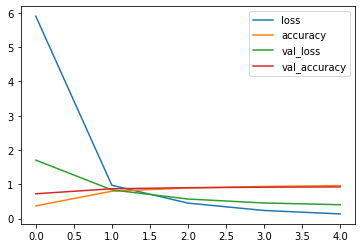

In [47]:
pd.DataFrame(history_3.history).plot()

### 4th Model - VGG16 - Top False w/ Extra Dense Layer

- Add an extra Dense layer with 1000 units before the output layer

In [52]:
i = tf.keras.layers.Input(shape=[224,224,3], dtype=tf.uint8)

x = tf.cast(i, tf.float32)

x = tf.keras.applications.vgg16.preprocess_input(x)

base_model = VGG16(
    include_top=False,
    pooling='avg',
)

for layer in base_model.layers:
  layer.trainable = False

x = base_model(x)

# Dense Fully Connected Layer
x = Dense(1000, activation='relu')(x)

# Connected category Dense Layer
x = Dense(26)(x)

# Output Layer for mixed precision
output = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)

model_4 = Model(i, output)

model_4.build(input_shape=(224,224,3))


model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)


Epoch 1/5
96/96 [==============================] - 11s 99ms/step - loss: 1.2883 - accuracy: 0.8001 - val_loss: 0.4336 - val_accuracy: 0.9231
Epoch 2/5
96/96 [==============================] - 9s 96ms/step - loss: 0.1596 - accuracy: 0.9574 - val_loss: 0.2474 - val_accuracy: 0.9462
Epoch 3/5
96/96 [==============================] - 9s 97ms/step - loss: 0.0608 - accuracy: 0.9816 - val_loss: 0.2826 - val_accuracy: 0.9538
Epoch 4/5
96/96 [==============================] - 9s 94ms/step - loss: 0.0221 - accuracy: 0.9918 - val_loss: 0.2722 - val_accuracy: 0.9615
Epoch 5/5
96/96 [==============================] - 9s 94ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.4068 - val_accuracy: 0.9462


In [51]:
model_4.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_16 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_16  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_16 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_14 (Dense)            (None, 1000)              513

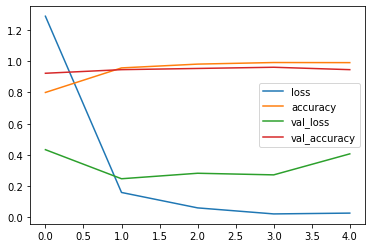

In [53]:
pd.DataFrame(history_4.history).plot()

### Run evaluations and predictions

- Use Model 4

In [62]:
y_true = []
preds = []

def predictor(path, image):
  target = path + '/' + image
  category = path.split('/')[1]

  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [224,224])
  # img = img/255.
  img = tf.expand_dims(img, axis=0)

  pred = np.argmax(model_4.predict(img), axis=1)

  preds.append(pred[0])

  y_true.append(class_names[category])

for dirs, fols, files in os.walk('test'):
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

In [55]:
class_names

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

In [64]:
len(y_true) == len(preds)

True

In [58]:
set(y_true) == set(preds)

False

In [63]:
set(preds)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [65]:
import seaborn as sns

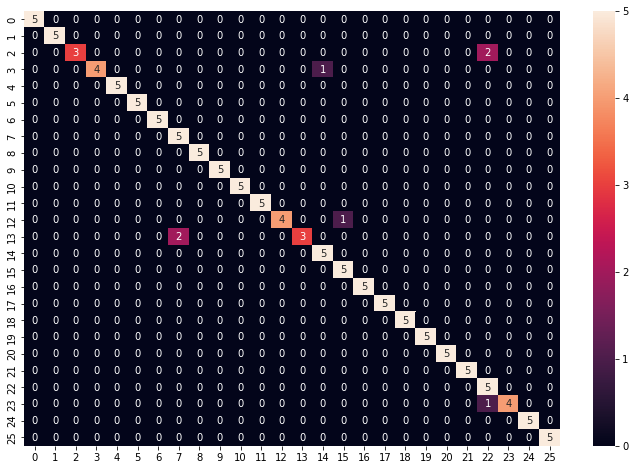

In [67]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_true, preds), annot=True)

In [68]:
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.00      0.60      0.75         5
          14       0.83      1.00      0.91         5
          15       0.83      1.00      0.91         5
          16       1.00      1.00      1.00         5
          17       1.00    